###### Select the soil_moisture from SMAP L3 Passive Soil Moisture (SPL3SMP.003) for Simi Valley, CA the (34.231, -118.661, 34.311, -118.869) for 1 April 2015 through 1 June 2016

In [2]:
%matplotlib inline
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import urllib
from mpl_toolkits.basemap import Basemap
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime, timedelta
from urllib.error import HTTPError

TIMEFRAME = [datetime(2015, 4, 1), datetime(2016, 6, 1)]
#TIMEFRAME = [datetime(2015, 5, 1), datetime(2015, 5, 5)]
SMAP_LOCAL_FILE_URL = "./SMAP/SMAP_L3_SM_P_{}_R13080_001.h5.nc"
SMAP_REMOTE_FILE_URL = "http://n5eil01u.ecs.nsidc.org:80/opendap/SMAP/SPL3SMP.003/{}/SMAP_L3_SM_P_{}_R13080_001.h5.nc"

#blatantly copied from http://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
def daterange(timeframe):
    for n in range(int ((timeframe[1] - timeframe[0]).days)):
        yield timeframe[0] + timedelta(n)        

def form_smashed_date(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)
        
def form_dotted_date(date):
    return str(date.year) + "." + str(date.month).zfill(2) + "." + str(date.day).zfill(2)

def download_smap_file(date):
    file_name = SMAP_LOCAL_FILE_URL.format(form_smashed_date(date))
    opendap_smap_url = SMAP_REMOTE_FILE_URL.format(form_dotted_date(date), form_smashed_date(date))
    try:
        print("trying to download " + file_name)
        file, headers = urllib.request.urlretrieve(opendap_smap_url, file_name)
    except HTTPError as e:
        print("couldn't download " + file_name + ", " + str(e))


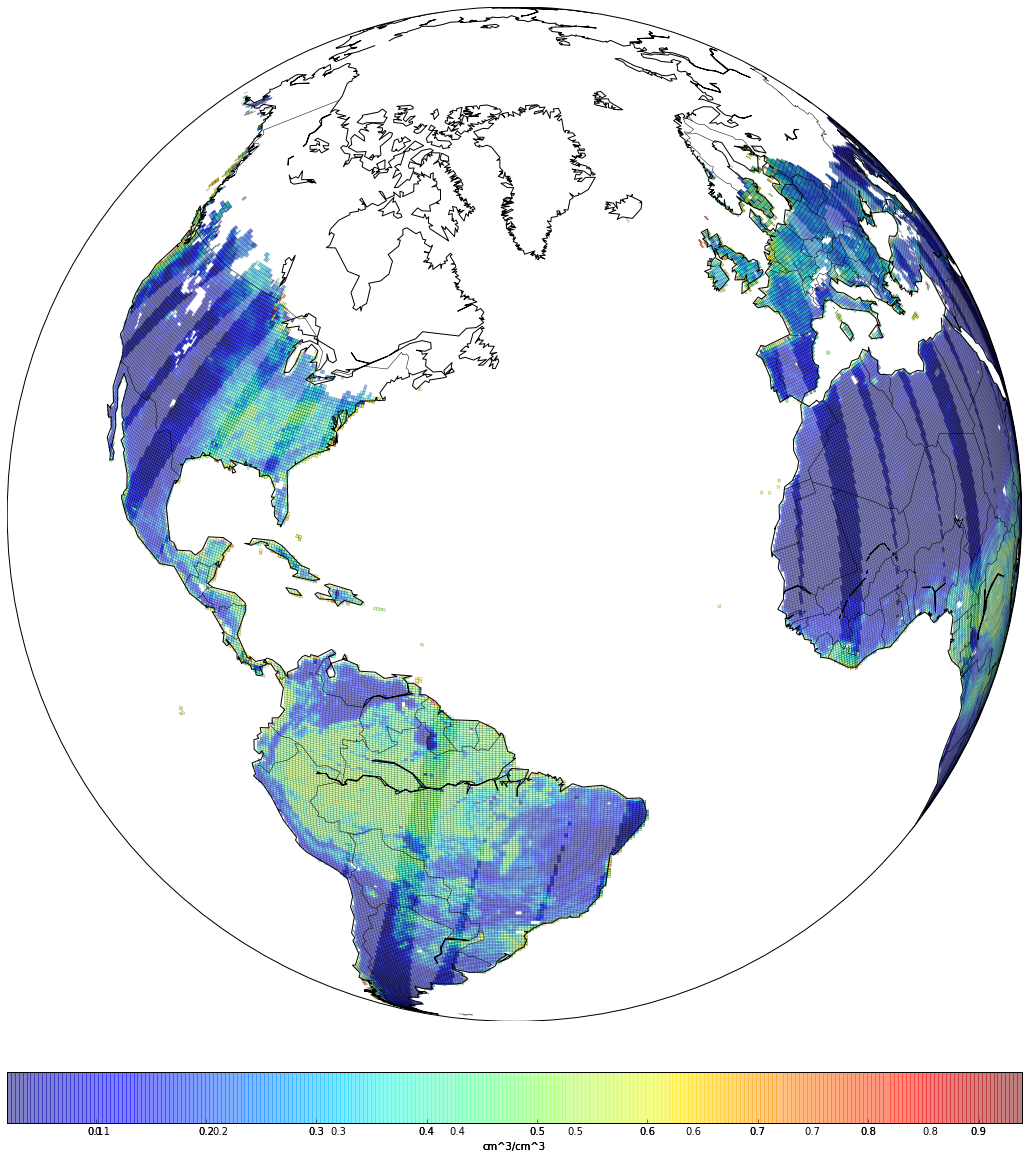

In [3]:
%matplotlib inline

def setup_plot():
    m = Basemap(projection='ortho',lat_0=30,lon_0=-50,resolution='c')
    m.drawcoastlines()
    m.drawcountries()
    return m

def plot_smap_dataset(basemap, dataset):
    lat = dataset.variables["Soil_Moisture_Retrieval_Data_latitude"][:,:]
    lon = dataset.variables["Soil_Moisture_Retrieval_Data_longitude"][:,:]
    mos = dataset.variables["Soil_Moisture_Retrieval_Data_soil_moisture"][:,:]
    
    cs = basemap.pcolor(lon, lat, mos, alpha=0.5, edgecolors=None, latlon=True)
    cbar = basemap.colorbar(cs, location='bottom', pad='5%')
    cbar.set_label("cm^3/cm^3")
   
@interact(selected_date=widgets.IntSlider(min=1427846400, max=1464739200, step=259200, value=1427846400,
                                          continuous_update=False,description="Date: ",readout_format=''))
def get_dataset(selected_date=1430438400):
    converted_date = datetime.fromtimestamp(selected_date)
    three_day_timeframe = [converted_date, converted_date+timedelta(3)]
    plot = plt.figure(figsize=(20,20))
    m = setup_plot()
    for date in daterange(three_day_timeframe):
        local_smap_url = SMAP_LOCAL_FILE_URL.format(form_smashed_date(date))
        try:
            dataset = netCDF4.Dataset(local_smap_url)
        except OSError as e:
            print("oops, couldn't find " + local_smap_url)
            download_smap_file(date)
        else:
            plot_smap_dataset(m, dataset)
    